In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import scipy.stats as stats
import sklearn.metrics as metrics
import numpy as np

## 数据分布的概念
- $P(X)$
    - 本质上就是一个函数，值域(Range)固定在 [0, 1]。定义域及映射决定了这个「分布」 
    - 就其一般形式，$X$ 只要是一个集合即可。机器学习中常用的就是 $\mathbb{R}^N$ 即 N 维数组

### 简单的二分类数据分布

In [3]:
class0_data = np.random.rand(200, 2)
class1_data = np.random.rand(200, 2) + 3
# test2

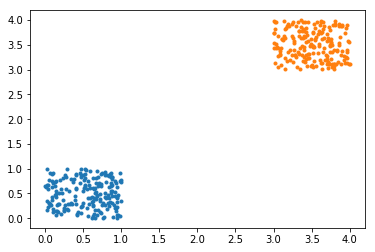

In [4]:
plt.plot(class0_data[:, 0], class0_data[:, 1], '.', class1_data[:, 0], class1_data[:, 1], '.');

上面这个例子是来自 $\mathbb{R}^2$ 的两类数据的「分布」，即 $P(X|y=0)$ 及 $P(X|y=1)$

## Discriminative vs Generative model

Generative Model 的典型例子是朴素贝叶斯，通过 Generative Model 可以计算 $P(X, y)$ 的联合分布。Discriminatve Model 的典型例子是 Logistic Regression，其只能直接得到 $P(y|X)$。



References:
- Pluskid, Discriminative Modeling vs Generative Modeling. http://freemind.pluskid.org/machine-learning/discriminative-modeling-vs-generative-modeling/
- Andrew Y. Ng and Michael I. Jordan. 2002. On discriminative vs. generative classifiers: A comparison of logistic regression and naive bayes. In T. G. Dietterich, S. Becker, & Z. Ghahramani, eds. Advances in neural information processing systems 14. MIT Press, 841–848.

In [5]:
def truncated_norm(lower, upper, mu, sigma):
    a = (lower - mu) / sigma
    b = (upper - mu) / sigma
    return stats.truncnorm(a, b, loc=mu, scale=sigma)

real_data = truncated_norm(0, 1, 0.5, 0.2).rvs(1000)
noise_data = stats.uniform(loc=0, scale=1).rvs(1000)
forge_data = truncated_norm(0, 1, 0.5, 0.2).rvs(1000)

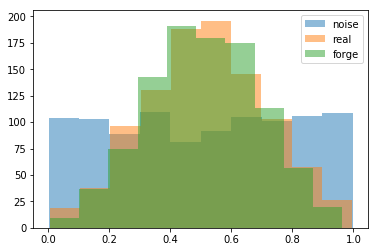

In [6]:
plt.hist(noise_data, alpha=0.5, label='noise');
plt.hist(real_data, alpha=0.5, label='real');
plt.hist(forge_data, alpha=0.5, label='forge');
plt.legend();